<a href="https://colab.research.google.com/github/harvardnlp/pytorch-struct/blob/master/notebooks/BertDependencies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://github.com/harvardnlp/pytorch-struct/blob/master/notebooks/BertTagger.ipynb

# !pip install -qqq torchtext wandb
# !pip install -qqq pytorch-transformers
# !pip install -qqqU git+https://github.com/harvardnlp/pytorch-struct
# !git clone -q http://github.com/srush/temp

In [2]:
import torchtext
import torch
import torch.nn as nn
from torch_struct import DependencyCRF
import torch_struct.data
import torchtext.data as data
from pytorch_transformers import AdamW, WarmupLinearSchedule
from pytorch_transformers import *
import matplotlib.pyplot as plt


config = {"bert": "bert-base-cased", "H" : 768, "dropout": 0.2
         }

# Comment or add your wandb
# import wandb
# wandb.init(project="pytorch-struct-tagging", config=config)

Parse the conll dependency data.

TorchText batching setup.

In [4]:
model_class, tokenizer_class, pretrained_weights = BertModel, BertTokenizer, config['bert']
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
WORD = torch_struct.data.SubTokenizedField(tokenizer)

def batch_num(nums):
    lengths = torch.tensor([len(n) for n in nums]).long()
    n = lengths.max()
    out = torch.zeros(len(nums), n).long()
    for b, n in enumerate(nums):
        out[b, :len(n)] = torch.tensor(n)
    return out, lengths
HEAD = data.RawField(preprocessing= lambda x: [int(i) for i in x],
                     postprocessing=batch_num)
HEAD.is_target = True

train = torch_struct.data.ConllXDataset("wsj.train0.conllx", (('word', WORD), ('head', HEAD)),
                     filter_pred=lambda x: 5 < len(x.word[0]) < 40)
#train_iter = torchtext.data.BucketIterator(train, batch_size=3, device="cpu", shuffle=False)
train_iter = torch_struct.data.TokenBucket(train, batch_size=3, device="cpu")


val = torch_struct.data.ConllXDataset("wsj.train0.conllx", (('word', WORD), ('head', HEAD)),
                     filter_pred=lambda x: 5 < len(x.word[0]) < 40)
val_iter = torchtext.data.BucketIterator(val, batch_size=3, device="cpu", shuffle=False)

In [4]:
# for i, x in enumerate(train_iter):
#     print(i)
#     print(x.word[0].shape) #word sq.s
#     print(x.word[1].shape) #mapper : b x max_bert_tok_len x max_word_len+2 (ie bos, eos)
#     print(x.word[2]) #bert_tok_lengths
#     print(x.head[0].shape)
#     print(x.head[1])

# for i, x in enumerate(val_iter):
#     print(i)
#     print(x.word[0].shape) #word sq.s
#     print(x.word[1].shape) #mapper : b x max_bert_tok_len x max_word_len+2
#     print(x.word[2]) #bert_tok_lengths
#     print(x.head[0].shape)
#     print(x.head[1])

In [5]:
# y = next(iter(train_iter))
# #y.word 
# y.word[0].shape, y.word[0][0], y.word[1].shape, y.word[1][0], y.word[2]

Make a Bert model to compute the potentials

In [9]:
H = config["H"]
class Model(nn.Module):
    def __init__(self, hidden):
        super().__init__()
        self.base_model = model_class.from_pretrained(pretrained_weights)
        self.linear = nn.Linear(H, H)
        self.bilinear = nn.Linear(H, H)
        self.root = nn.Parameter(torch.rand(H))
        self.dropout = nn.Dropout(config["dropout"])
        
    def forward(self, words, mapper):
        out = self.dropout(self.base_model(words)[0])
        out = torch.einsum("bca,bch->bah", mapper.float(), out) #.cuda()
        final2 = torch.einsum("bnh,hg->bng", out, self.linear.weight)
        final = torch.einsum("bnh,hg,bmg->bnm", out, self.bilinear.weight, final2)
        root_score = torch.einsum("bnh,h->bn", out, self.root)
        final = final[:, 1:-1, 1:-1]
        N = final.shape[1]
        final[:, torch.arange(N), torch.arange(N)] += root_score[:, 1:-1]
        return final

model = Model(H)
#wandb.watch(model)
#model.cuda()
None

Generic training loop. 

In [10]:
def show_deps(tree):
    plt.imshow(tree.detach())
    
def validate(val_iter):
    incorrect_edges = 0
    total_edges = 0
    model.eval()
    for i, ex in enumerate(val_iter):
        words, mapper, _ = ex.word
        label, lengths = ex.head
        batch, _ = label.shape

        final = model(words, mapper) #.cuda()
        for b in range(batch):
            final[b, lengths[b]-1:, :] = 0
            final[b, :, lengths[b]-1:] = 0
        dist = DependencyCRF(final, lengths=lengths)
        argmax = dist.argmax
        gold = dist.struct.to_parts(label, lengths=lengths).type_as(argmax)
        incorrect_edges += (argmax[:, :].cpu() - gold[:, :].cpu()).abs().sum() / 2.0
        total_edges += gold.sum()  

        gold1 = DependencyCRF(gold, lengths=lengths)

    print(total_edges, incorrect_edges)   
    model.train()
    return gold1

def train(train_iter, val_iter, model):
    opt = AdamW(model.parameters(), lr=1e-4, eps=1e-8)
    scheduler = WarmupLinearSchedule(opt, warmup_steps=20, t_total=2500)
    for epoch in range(50):
        #print(epoch)
        model.train()
        losses = []

        for i, ex in enumerate(train_iter):
            opt.zero_grad()
            words, mapper, _ = ex.word
            #print(words.shape, mapper.shape)
            label, lengths = ex.head
            batch, _ = label.shape

            # Model
            final = model(words, mapper) #.cuda()
            #print('final', final.shape)
    #         for b in range(batch):
    #             final[b, lengths[b]-1:, :] = 0
    #             final[b, :, lengths[b]-1:] = 0

    #         print(2, final.shape, final)

    #       if not lengths.max() == final.shape[1]:
            if not lengths.max() <= final.shape[1] + 1:
                print("fail")
                continue

            dist = DependencyCRF(final, lengths=lengths)
            #print('dist', dist.argmax.shape)

            labels = dist.struct.to_parts(label, lengths=lengths).type_as(final)
            #print('labels', labels.shape)
            log_prob = dist.log_prob(labels)

            loss = log_prob.sum()
            (-loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            opt.step()
            scheduler.step()
            losses.append(loss.detach())
        #print(-torch.tensor(losses).mean())

        if epoch % 10 == 1:            
            print(i, -torch.tensor(losses).mean(), words.shape)
            losses = []
            show_deps(dist.argmax[0])
            plt.show()
            
        if epoch % 10 == 1:
            gold = validate(val_iter)        
            show_deps(gold.argmax[0])
            plt.show()

3 tensor(115.9327) torch.Size([1, 19])


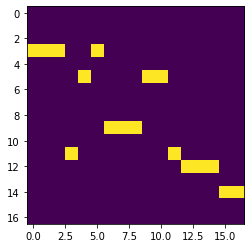

tensor(157.) tensor(110.)


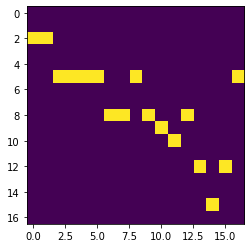

In [ ]:
train(train_iter, val_iter, model)